## GCM-Filters

gcm-filters (https://gcm-filters.readthedocs.io/) uses a laplacian-based method to smooth any field. The method is complementary to corase-granning. For a comparison purpose, we use gcm-filters to compute barotropic vorticity diagnostics at 1-10 degree resolution.

In [1]:
import xarray as xr
import numpy as np
from xgcm import Grid
import regionmask
import gcm_filters
import matplotlib.pyplot as plt

In [2]:
ds_vort = xr.open_dataset("../../Data/OM4p25_JRA55_Vorticity_Budget_1958_2017_Mean.nc")

var_list = ['beta_V', 'BPT', 'Curl_Adv', 'Curl_taus', 'Curl_taub', 
            'Curl_diff', 'Mass_flux', 'Curl_dudt', 'eta_dt']

ds2 = ds_vort.get(var_list).astype(np.float64)
wet_mask = ds_vort['wet_c'].astype(np.float64)
area = ds_vort['areacello_bu'].astype(np.float64)

print(ds2)

<xarray.Dataset>
Dimensions:    (yq: 1080, xq: 1440)
Coordinates:
  * xq         (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yq         (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
Data variables:
    beta_V     (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    BPT        (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Curl_Adv   (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Curl_taus  (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Curl_taub  (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Curl_diff  (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Mass_flux  (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Curl_dudt  (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    eta_dt     (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan


In [6]:
# use gcm_filters to filter using a fixed coarsening factor

ds_save = []

for i in range(1,11):
    
    factor = 4*i # to i deg
    dx_min = 1
    filter_shape = gcm_filters.FilterShape.TAPER #.GAUSSIAN

    filter_tripolar_regular_with_land = gcm_filters.Filter(filter_scale=factor, dx_min=1,
        filter_shape=filter_shape, grid_type=gcm_filters.GridType.TRIPOLAR_REGULAR_WITH_LAND_AREA_WEIGHTED,
        grid_vars={'area': area, 'wet_mask': wet_mask})
    
    print(filter_tripolar_regular_with_land)
    
    %time ds_smooth = filter_tripolar_regular_with_land.apply(ds2, dims=['yq', 'xq'])
    
    ds_save.append(ds_smooth)

    
ds_save = xr.concat(ds_save, dim='filter_scale')

save_file = "../../Data/GCM_filters/Vorticity_filter_1_10.nc"

ds_save.to_netcdf(save_file)

print("data saved succefully")

data saved succefully


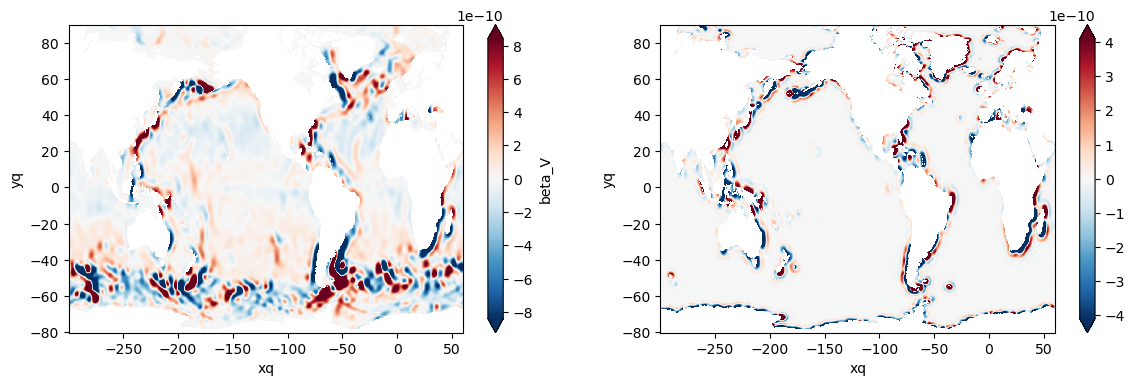

In [14]:
# check the budget is closed after filtering

tmp = ds_save.isel(filter_scale=4)

fig = plt.figure(figsize=[14,4])

plt.subplot(1,2,1)
tmp['beta_V'].plot(robust=True) # this is just noise

tmp = (tmp['beta_V'] - tmp['BPT'] - tmp['Curl_Adv'] - tmp['Curl_taus'] - tmp['Curl_taub'] 
       - tmp['Curl_diff'] - tmp['Mass_flux'] - tmp['Curl_dudt'] - tmp['eta_dt'])

plt.subplot(1,2,2)
tmp.plot(robust=True) # this is just noise

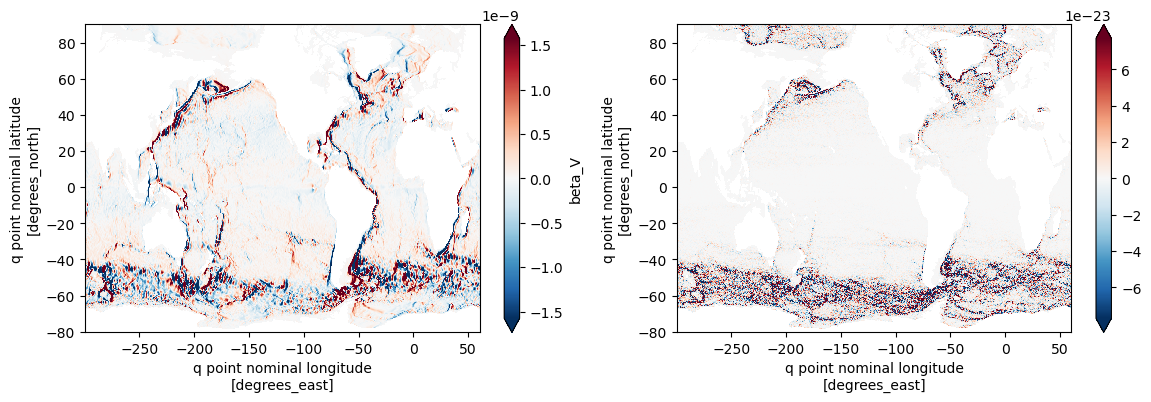

In [13]:
# original data

tmp = ds2

fig = plt.figure(figsize=[14,4])

plt.subplot(1,2,1)
tmp['beta_V'].plot(robust=True) # this is just noise

tmp = (tmp['beta_V'] - tmp['BPT'] - tmp['Curl_Adv'] - tmp['Curl_taus'] - tmp['Curl_taub'] 
       - tmp['Curl_diff'] - tmp['Mass_flux'] - tmp['Curl_dudt'] - tmp['eta_dt'])

plt.subplot(1,2,2)
tmp.plot(robust=True) # this is just noise

#### Large residuals after filtering

Let's check what causes large residuals. It is probably reltaed to land mask. Let's ignore land mask and fill land values with 0 and if the same issue persists.

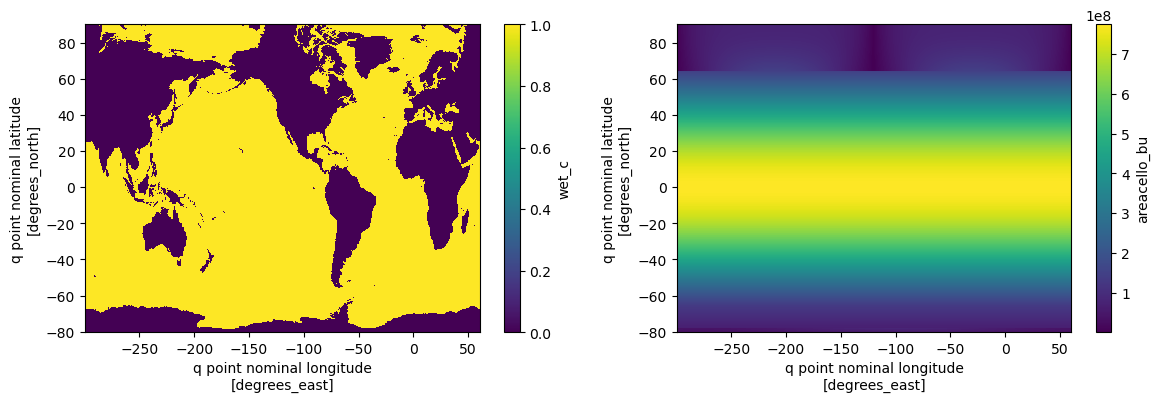

In [6]:
# checking mask and area are correct

fig = plt.figure(figsize=[14,4])

plt.subplot(1,2,1)
wet_mask.plot()

plt.subplot(1,2,2)
area.plot()

In [4]:
factor = 4*5 # to i deg
dx_min = 1
filter_shape = gcm_filters.FilterShape.TAPER #.GAUSSIAN

filter_tripolar_regular_with_land = gcm_filters.Filter(filter_scale=factor, dx_min=1,
        filter_shape=filter_shape, grid_type=gcm_filters.GridType.REGULAR_AREA_WEIGHTED,
        grid_vars={'area': area})
    
print(filter_tripolar_regular_with_land)
    
%time ds_smooth = filter_tripolar_regular_with_land.apply(ds2.fillna(0.), dims=['yq', 'xq'])

ds_tmp = ds2.get(['beta_V', 'BPT'])
ds_tmp['beta_V_half'] = 0.5 * ds_tmp['beta_V']
ds_tmp['sum'] = ds_tmp['beta_V'] + ds_tmp['BPT']

%time ds_tmp_smooth = filter_tripolar_regular_with_land.apply(ds_tmp.fillna(0.), dims=['yq', 'xq'])

Filter(filter_scale=20, dx_min=1, filter_shape=<FilterShape.TAPER: 2>, transition_width=3.141592653589793, ndim=2, n_steps=78, grid_type=<GridType.REGULAR_AREA_WEIGHTED: 2>)
CPU times: user 6.73 s, sys: 3.52 s, total: 10.2 s
Wall time: 10.3 s
CPU times: user 2.94 s, sys: 1.55 s, total: 4.49 s
Wall time: 4.49 s


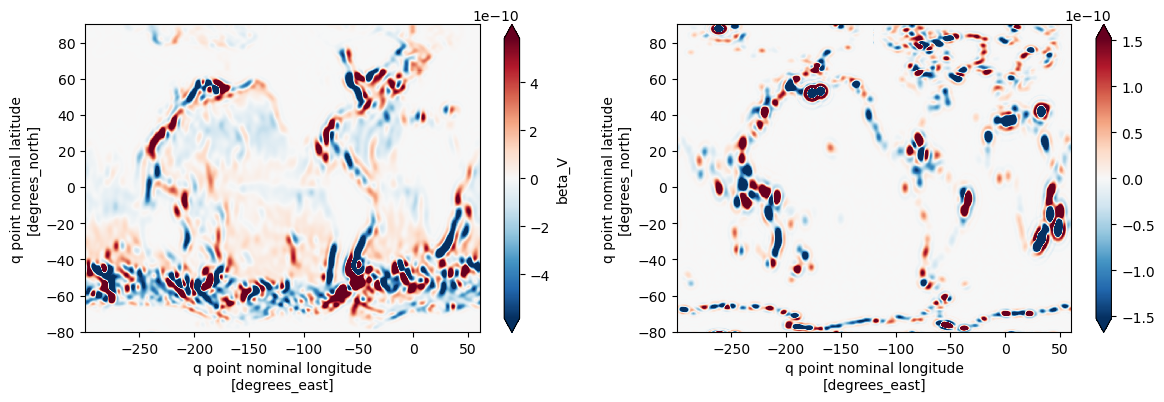

In [14]:
# check the budget is closed after filtering

tmp = ds_smooth

fig = plt.figure(figsize=[14,4])

plt.subplot(1,2,1)
tmp['beta_V'].plot(robust=True) # this is just noise

tmp1 = (tmp['beta_V'] - tmp['BPT'] - tmp['Curl_Adv'] - tmp['Curl_taus'] - tmp['Curl_taub'] 
       - tmp['Curl_diff'] - tmp['Mass_flux'] - tmp['Curl_dudt'] - tmp['eta_dt'])

plt.subplot(1,2,2)
tmp1.plot(robust=True) # this is just noise

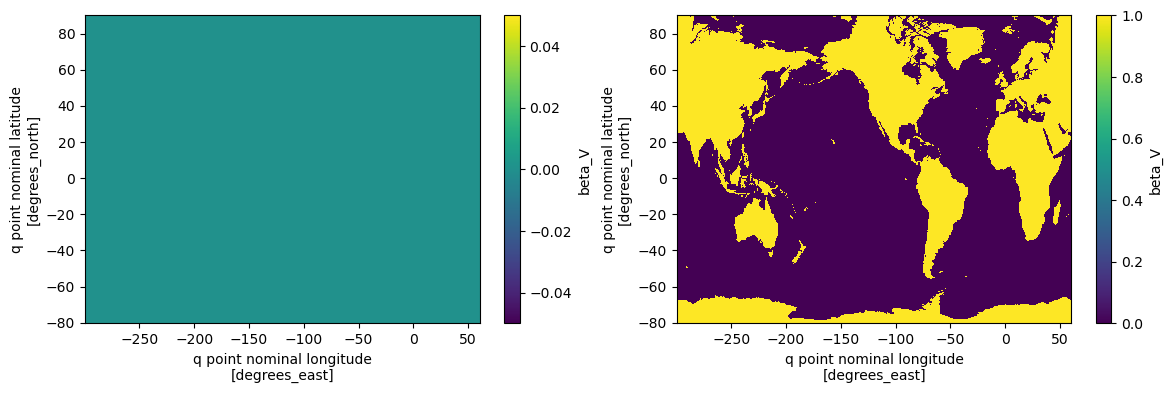

In [6]:
fig = plt.figure(figsize=[14,4])

plt.subplot(1,2,1)

np.isnan(ds_smooth['beta_V']).plot()

plt.subplot(1,2,2)

np.isnan(ds2['beta_V']).plot()

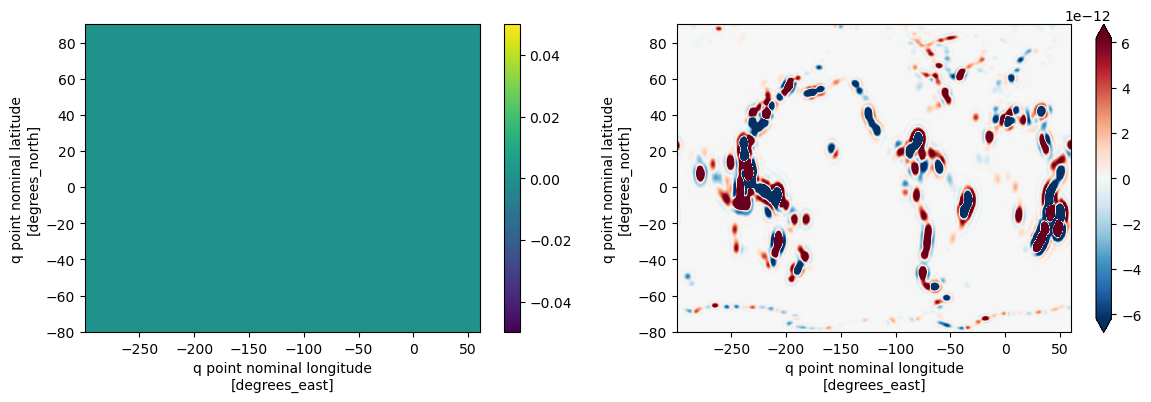

In [13]:
fig = plt.figure(figsize=[14,4])

plt.subplot(1,2,1)

(ds_tmp_smooth['beta_V_half']*2.0 - ds_tmp_smooth['beta_V']).plot(robust=True)

plt.subplot(1,2,2)

(ds_tmp_smooth['sum'] - ds_tmp_smooth['beta_V'] - ds_tmp_smooth['BPT']).plot(robust=True)

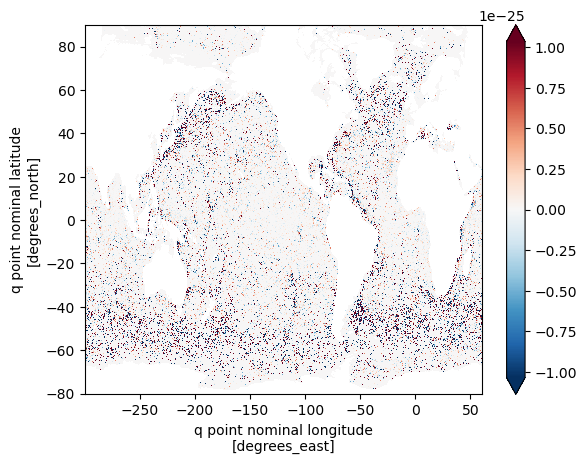

In [14]:
(ds_tmp['sum'] - ds_tmp['beta_V'] - ds_tmp['BPT']).plot(robust=True)

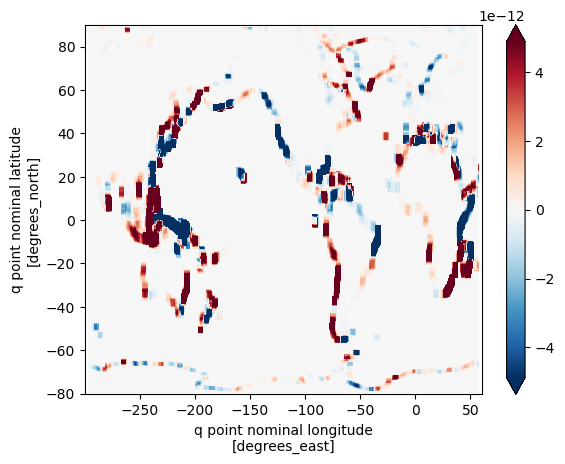

In [19]:
### Try with rolling means

tmp1 = ds_tmp['sum'].fillna(0.).rolling({"xq":20,"yq":20}, center=True).mean()
tmp2 = ds_tmp['beta_V'].fillna(0.).rolling({"xq":20,"yq":20}, center=True).mean()
tmp3 = ds_tmp['BPT'].fillna(0.).rolling({"xq":20,"yq":20}, center=True).mean()

(tmp1 - tmp2 - tmp3).plot(robust=True)